In [13]:
!pip install deap
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install numpy
!pip install matplotlib



In [14]:
!pip install IPython
!pip install time
!pip install random

ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time
ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random


1

In [15]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

epochs_per_generation = 5
generations = 10

# Classe para armazenar os melhores genes e plotar os resultados
class DynamicPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self, generation, epoch, gene_log):
        self.epoch_losses = []
        self.epoch_accuracies = []
        self.generation = generation
        self.epoch = epoch
        self.gene_log = gene_log

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_losses.append(logs['loss'])
        self.epoch_accuracies.append(logs['accuracy'])
        # Armazenar genes dos epochs com melhor acurácia
        if len(self.epoch_accuracies) == 0 or logs['accuracy'] > max(self.epoch_accuracies):
            self.gene_log.append((self.generation, self.epoch, logs['accuracy']))




2

In [16]:
# Carregar os dados
def load_titanic_data():
    url = "https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv"
    data = pd.read_csv(url)

    # Remover colunas que não serão usadas
    data = data.drop(['Name'], axis=1)

    # Tratar valores ausentes
    data = data.dropna()

    # Codificar colunas categóricas
    label_encoder = LabelEncoder()
    data['Sex'] = label_encoder.fit_transform(data['Sex'])

    if 'Embarked' in data.columns:
        data['Embarked'] = label_encoder.fit_transform(data['Embarked'])

    # Separar dados de entrada e saída
    X = data.drop('Survived', axis=1).values
    y = data['Survived'].values

    # Normalizar dados de entrada
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Dividir dados em treino e teste
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = load_titanic_data()


3

In [17]:
# Funções para treinar classificadores
def train_knn(X_train, y_train, X_test):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    return knn

def train_random_forest(X_train, y_train, X_test):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    return rf

def train_svm(X_train, y_train, X_test):
    svm = SVC(kernel='linear', random_state=42)
    svm.fit(X_train, y_train)
    return svm

def train_naive_bayes(X_train, y_train, X_test):
    nb = GaussianNB()
    nb.fit(X_train, y_train)
    return nb



4

In [18]:
# Função para criar o modelo de rede neural
def create_model(units, layers, optimizer):
    model = Sequential()
    model.add(Dense(units=units, activation='relu', input_shape=(X_train.shape[1],)))
    for _ in range(layers - 1):
        model.add(Dense(units=units, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Função de avaliação para o algoritmo genético
def evaluate(individual):
    units, layers, optimizer_idx = individual
    optimizers = [Adam(), SGD(), RMSprop()]
    optimizer = optimizers[optimizer_idx]
    gene_log = []
    callback = DynamicPlotCallback(generation=generation, epoch=epoch, gene_log=gene_log)
    model = create_model(units, layers, optimizer)
    start_time = time.time()
    model.fit(X_train, y_train, epochs=epochs_per_generation, batch_size=32, verbose=0, callbacks=[callback])
    duration = time.time() - start_time
    print(f'Training time for this individual: {duration:.2f} seconds')
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy,




4-a

In [19]:
# Função para treinar e avaliar uma rede neural simples
def train_simple_nn(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=epochs_per_generation, batch_size=32, verbose=0)

    # Avaliar o modelo
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return model, accuracy

# Treinar e avaliar a rede neural simples
simple_nn_model, simple_nn_accuracy = train_simple_nn(X_train, y_train, X_test, y_test)
print("Simple NN Test Accuracy:", simple_nn_accuracy)



Simple NN Test Accuracy: 0.7584269642829895


5

In [20]:
# Configuração do algoritmo genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 100)  # Neurônios
toolbox.register("attr_layers", random.randint, 1, 3)  # Camadas
toolbox.register("attr_optimizer", random.randint, 0, 2)  # Otimizadores: 0=Adam, 1=SGD, 2=RMSprop
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_layers, toolbox.attr_optimizer), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Hall of Fame para armazenar os melhores indivíduos
hof = tools.HallOfFame(1)





/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/usr/local/lib/python3.10/dist-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


6

In [21]:
# Executar o algoritmo genético
population = toolbox.population(n=10)
gene_log = []

for generation in range(generations):
    print(f"Generation {generation+1}/{generations}")
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=1, halloffame=hof, verbose=False)

# Melhor indivíduo do Hall of Fame
best_individual = hof[0]
best_units, best_layers, best_optimizer_idx = best_individual
print("Best individual units:", best_units)
print("Best individual layers:", best_layers)
print("Best individual optimizer:", ['Adam', 'SGD', 'RMSprop'][best_optimizer_idx])






Generation 1/10
Training time for this individual: 2.27 seconds
Training time for this individual: 2.19 seconds
Training time for this individual: 4.47 seconds
Training time for this individual: 2.63 seconds
Training time for this individual: 2.11 seconds
Training time for this individual: 2.36 seconds
Training time for this individual: 2.44 seconds
Training time for this individual: 3.79 seconds
Training time for this individual: 2.50 seconds
Training time for this individual: 1.20 seconds
Training time for this individual: 1.20 seconds
Training time for this individual: 1.16 seconds
Training time for this individual: 2.15 seconds
Training time for this individual: 2.18 seconds
Training time for this individual: 1.86 seconds
Training time for this individual: 1.07 seconds
Training time for this individual: 1.20 seconds
Training time for this individual: 1.03 seconds
Training time for this individual: 1.86 seconds
Generation 2/10
Training time for this individual: 2.09 seconds
Training

7

In [22]:
# Função para treinar a rede neural otimizada por algoritmo genético usando validação cruzada
def evaluate_genetic_model(units, layers, optimizer_idx, X, y):
    optimizers = [Adam(), SGD(), RMSprop()]
    optimizer = optimizers[optimizer_idx]
    gene_log = []
    callback = DynamicPlotCallback(generation=generation, epoch=epoch, gene_log=gene_log)
    model = create_model(units, layers, optimizer)
    scores = []
    for train_index, test_index in StratifiedKFold(n_splits=5).split(X, y):
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(X_train_fold, y_train_fold, epochs=epochs_per_generation, batch_size=32, verbose=0, callbacks=[callback])
        _, accuracy = model.evaluate(X_test_fold, y_test_fold, verbose=0)
        scores.append(accuracy)
    return np.mean(scores)

# Avaliar a rede neural otimizada por algoritmo genético usando validação cruzada
genetic_nn_cv_accuracy = evaluate_genetic_model(best_units, best_layers, best_optimizer_idx, X_train, y_train)
print("Genetic NN CV Accuracy:", genetic_nn_cv_accuracy)

# Mostrar o head do dataframe com os melhores genes
gene_df = pd.DataFrame(gene_log, columns=['Generation', 'Epoch', 'Accuracy'])
print(gene_df.head())



Genetic NN CV Accuracy: 0.8350214719772339
Empty DataFrame
Columns: [Generation, Epoch, Accuracy]
Index: []


8

In [23]:
# Treinar e avaliar KNN com validação cruzada
knn = train_knn(X_train, y_train, X_test)
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
knn_cv_accuracy = knn_cv_scores.mean()
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
print("KNN CV Accuracy:", knn_cv_accuracy)
print("KNN Test Accuracy:", knn_accuracy)
print("KNN Classification Report:\n", classification_report(y_test, knn_predictions))

# Treinar e avaliar Random Forest com validação cruzada
rf = train_random_forest(X_train, y_train, X_test)
rf_cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
rf_cv_accuracy = rf_cv_scores.mean()
rf_predictions = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
print("Random Forest CV Accuracy:", rf_cv_accuracy)
print("Random Forest Test Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", classification_report(y_test, rf_predictions))

# Treinar e avaliar SVM com validação cruzada
svm = train_svm(X_train, y_train, X_test)
svm_cv_scores = cross_val_score(svm, X_train, y_train, cv=5)
svm_cv_accuracy = svm_cv_scores.mean()
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM CV Accuracy:", svm_cv_accuracy)
print("SVM Test Accuracy:", svm_accuracy)
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

# Treinar e avaliar Naive Bayes com validação cruzada
nb = train_naive_bayes(X_train, y_train, X_test)
nb_cv_scores = cross_val_score(nb, X_train, y_train, cv=5)
nb_cv_accuracy = nb_cv_scores.mean()
nb_predictions = nb.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
print("Naive Bayes CV Accuracy:", nb_cv_accuracy)
print("Naive Bayes Test Accuracy:", nb_accuracy)
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))


KNN CV Accuracy: 0.8053541104784736
KNN Test Accuracy: 0.7808988764044944
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       111
           1       0.71      0.70      0.71        67

    accuracy                           0.78       178
   macro avg       0.77      0.77      0.77       178
weighted avg       0.78      0.78      0.78       178

Random Forest CV Accuracy: 0.8152332434322244
Random Forest Test Accuracy: 0.7696629213483146
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       111
           1       0.70      0.67      0.69        67

    accuracy                           0.77       178
   macro avg       0.76      0.75      0.75       178
weighted avg       0.77      0.77      0.77       178

SVM CV Accuracy: 0.796923384277295
SVM Test Accuracy: 0.7415730337078652
SVM Classification Report:
            

9

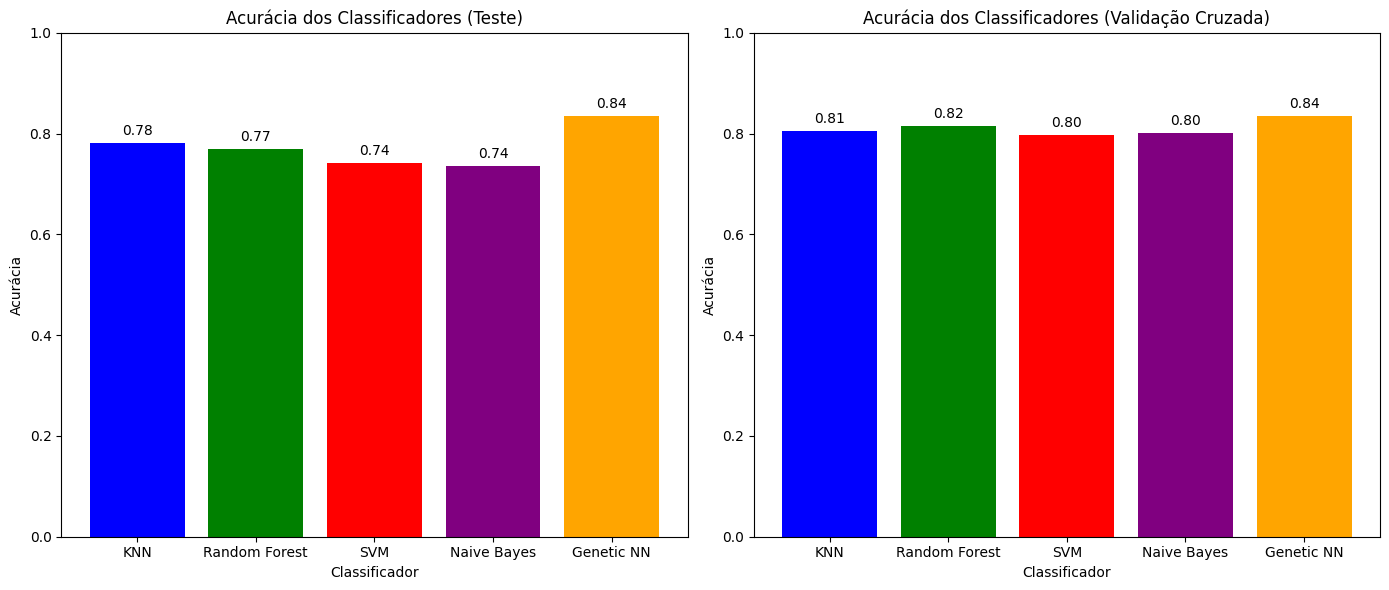

In [24]:
# Plotar gráficos de acurácia
classifiers = ['KNN', 'Random Forest', 'SVM', 'Naive Bayes', 'Genetic NN']
test_accuracies = [knn_accuracy, rf_accuracy, svm_accuracy, nb_accuracy, genetic_nn_cv_accuracy]
cv_accuracies = [knn_cv_accuracy, rf_cv_accuracy, svm_cv_accuracy, nb_cv_accuracy, genetic_nn_cv_accuracy]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(classifiers, test_accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Classificador')
plt.ylabel('Acurácia')
plt.title('Acurácia dos Classificadores (Teste)')
plt.ylim(0, 1)
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.bar(classifiers, cv_accuracies, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Classificador')
plt.ylabel('Acurácia')
plt.title('Acurácia dos Classificadores (Validação Cruzada)')
plt.ylim(0, 1)
for i, acc in enumerate(cv_accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

